# DSP QA Engineer Application

## Audio Processing

Turn the volume down to half. \
Execute the cells from top to bottom.

In [32]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io.wavfile
import scipy.signal
from IPython.display import Audio
from IPython.core.interactiveshell import InteractiveShell

# pytest api for jupyter notebook
import ipytest
ipytest.autoconfig()

# cell output config
InteractiveShell.ast_node_interactivity = "all"

# impulse response for the echo effect
fs, room_resp = scipy.io.wavfile.read("Hal9000/ImpRepEcho.wav")

# normalizes the amplitude to values between 0.0 and 1.0
def normalize(audio):
    audio /= np.max(np.abs(audio),axis=0)
    return audio

# simple delay effect    
def addDelay(feedback, delay, wave):
    wave_one = wave
    wave_two = wave
    
    #pad with 0s for element wise addition
    wave_one_pad = np.pad(wave_one,(0, delay), 'constant')
    wave_two_pad = np.pad(wave_two,(delay,0), 'constant')
    
    #delay magic
    wave_delay = np.add(np.multiply(wave_one_pad,feedback), wave_two_pad)
    
    return normalize(wave_delay)

# simple convolution echo
def addConvEcho(wave, resp):
    wave_echo = np.convolve(wave, resp)
    return normalize(wave_echo)

# simulates adc quantization errors
def addQuantizationNoise(wave, q_steps):
    q = np.multiply(wave, q_steps)
    q = np.around(q)
    
    return normalize(q)

# does an FFT and plots the spectrum
def plotFFT(wave, title="Spectrum"):
    # Compute the one-dimensional discrete Fourier Transform.
    fft_wave = np.fft.fft(wave)

    # Compute the Discrete Fourier Transform sample frequencies.
    fft_fre = np.fft.fftfreq(n=wave.size, d=1/fs)
    
    plt.style.use('dark_background')
    plt.plot(fft_fre, fft_wave.real, label="Real part")
    plt.xlim(0,6000)
    plt.ylim(0,600)
    plt.legend(loc=1)
    plt.title("%s" % title)
    plt.xlabel("fHz")

    plt.show()

# IIR Filters
def highPassFilter(wave, freq):
    sos = scipy.signal.butter(20, freq, 'highpass', fs=22050, output='sos')
    return scipy.signal.sosfilt(sos, wave)

def bandPassFilter(wave, freq_range=[200, 500]):
    sos = scipy.signal.butter(20, freq_range, 'bandpass', fs=22050, output='sos')
    return scipy.signal.sosfilt(sos, wave)

# coloured noise generator
def noiseGenerator(len, freq_range=[200, 500]):
    wave = np.random.random(size=len)
    return bandPassFilter(wave, freq_range)

# gives the sample positon at second x  
def secToSamplePositon(fs, sec):
    return np.floor(np.multiply(fs,sec)).astype(int)

# adjusts the volume
def adjustVolume(wave, factor=0.3):
    return np.multiply(wave, factor)

In [34]:
fs, a= scipy.io.wavfile.read("Hal9000/hadAnUpdate.wav")

split_index1 = secToSamplePositon(fs, 2)
split_index2 = secToSamplePositon(fs, 3)

# splitting up the tracks
c = a[(split_index2+1):]
b = a[(split_index1+1):split_index2]
a = a[0:split_index1]

a_quantized = addQuantizationNoise(a, 100)
b_delayed = addDelay(1.0, 3000, b)
c_with_echo = addConvEcho(c, room_resp)

# adding the tracks back together
a = np.concatenate((a_quantized, b_delayed, c_with_echo), axis=0)

a = normalize(a)
a = adjustVolume(a)

Audio(a, rate=fs, normalize=False)

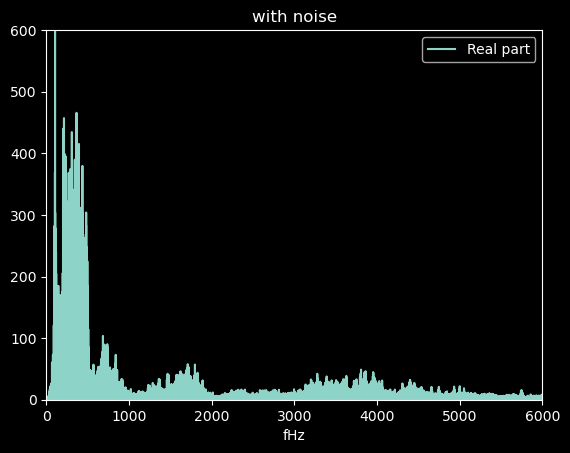

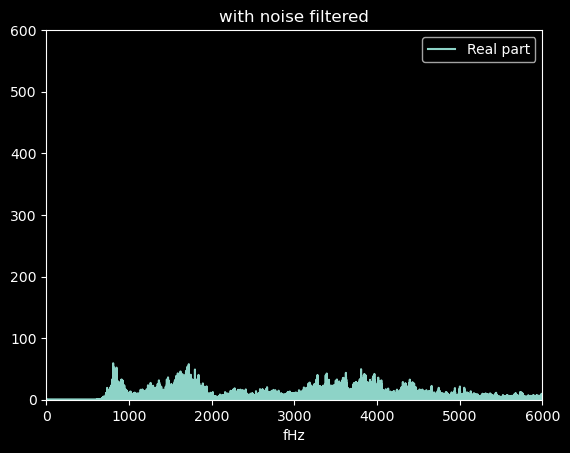

In [45]:
fs, a = scipy.io.wavfile.read("Hal9000/theNoise.wav")

# spooky space noise
b = noiseGenerator(a.size)

# adjust noise amplitude
b = adjustVolume(b, 0.5)

# mix both signals
c_unfiltered = np.add(a,b)

c = normalize(c_unfiltered)
c = adjustVolume(c)

Audio(c, rate=fs, normalize=False)

plotFFT(c_unfiltered, "with noise")

c_filtered = highPassFilter(c_unfiltered, 800)

plotFFT(c_filtered, "with noise filtered")

In [35]:
fs, a = scipy.io.wavfile.read("Hal9000/thatIsMuchBetter.wav")

b = noiseGenerator(a.size)

# adjust noise amplitude
b = adjustVolume(b, 0.05)

# mixing both tracks together
c = np.add(a,b)

c = highPassFilter(c, 800)

c = normalize(c)
c = adjustVolume(c)

Audio(c, rate=fs, normalize=False)

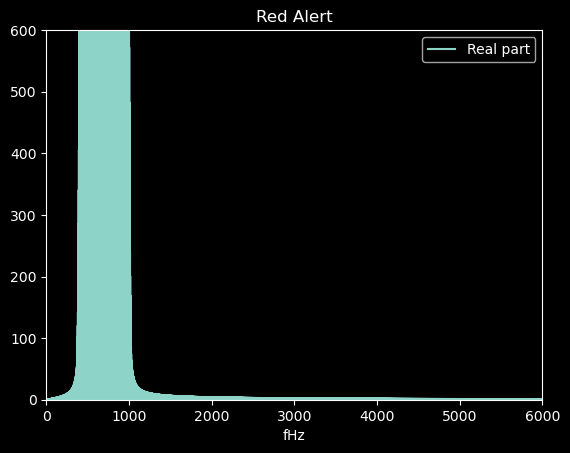

In [40]:
fs = 22050
t = np.arange(0, 0.5, 1/fs)

chirp = scipy.signal.chirp(t, f0=400, f1=1000, t1=0.5, method='linear')

# create red alert signal
red_alert = np.concatenate((chirp, chirp, chirp, 
    np.zeros(np.floor(fs/2).astype(int)), 
    chirp, chirp, chirp), axis=0)

plotFFT(red_alert, "Red Alert")

red_alert_out = normalize(red_alert)
red_alert_out = adjustVolume(red_alert, 0.07)

Audio(red_alert_out, rate=fs, normalize=False)

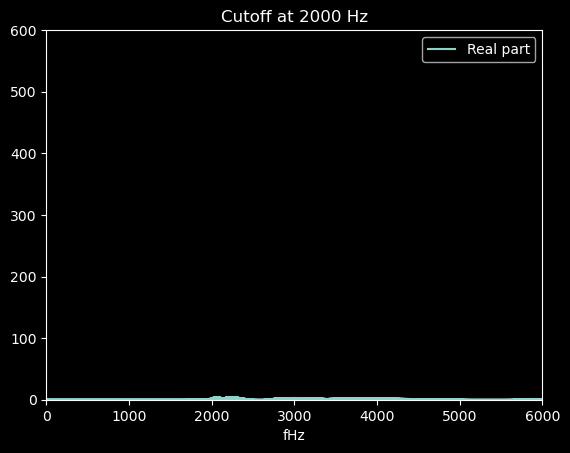

In [44]:
# pass the chirp signal through a filter
red_alert_filtered = highPassFilter(red_alert, 2000)

plotFFT(red_alert_filtered, "Cutoff at 2000 Hz")

# maximal amplitude in the filtered signal for the unit test
max_amp = np.amax(np.fft.fft(red_alert_filtered).real)

# threshold for the unit test
threshold = 10

## pytest 

In [42]:
%%ipytest -qq

def test_freq_below_threshold():
    assert max_amp < threshold 

.                                                                                            [100%]


In [43]:
%%ipytest -qq

def test_freq_above_threshold():
    assert max_amp > threshold

F                                                                                            [100%]
============================================ FAILURES =============================================
____________________________________ test_freq_above_threshold ____________________________________

    def test_freq_above_threshold():
>       assert max_amp > threshold
E       assert 3.9492941356624334 > 10

C:\Users\Chris\AppData\Local\Temp\ipykernel_17240\3257608492.py:2: AssertionError
===================================== short test summary info =====================================
FAILED t_c85cbc777a3a4e61a65113357461511c.py::test_freq_above_threshold - assert 3.94929413566243...


## ...more in Part 2